<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis - Final Project</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Data Processing</h2>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Julia King</h4>
</div>
<br>

In [1]:
# import chunk

from common_functions import confirm_execution, read_video_json, read_manual_sample, write_manual_sample, read_video_df, write_video_df, read_comment_df, write_comment_df, convert_conspirative_to_bool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# manual sample
import random
import csv
from sklearn.model_selection import train_test_split

# tkinter app
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import webbrowser

# text cleaning
import regex as re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download(["stopwords", "punkt", "wordnet"])
from sklearn.feature_extraction.text import CountVectorizer

# models
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# evaluation
from math import sqrt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 4. Based on the title and description, classify a sample of the videos as conspirative or non-conspirative by hand.

In [2]:
# load video json
video_json = read_video_json()

In [3]:
# function creating sample dataset

def sample_videos(video_json: list, n : int = 250, seed : int = 94) -> pd.DataFrame:
    # generate docstring by typing """
    
    # get n random videos
    random.seed(seed)
    vd_sample = random.sample(video_json, k = n)
    
    # create df
    sample = pd.DataFrame(data = {
        "video_id" : [video["video_id"] for video in vd_sample], 
        "title" : [video["metadata"]["snippet"]["title"] for video in vd_sample], 
        "description" : [video["metadata"]["snippet"]["description"] for video in vd_sample], 
        "conspirative" : pd.NA
    })
    return sample

In [4]:
# draw training sample

confirm_execution("Do you want to reset the manually evaluated sample?")

manual_sample = sample_videos(video_json, n = 400)

write_manual_sample(manual_sample)

Exception: Execution aborted by user.

In [5]:
# create tkinter app for labelling

class ConspiracyLabeler:
    def __init__(self, root, filepath):
        self.root = root
        self.filepath = filepath
        self.df = read_manual_sample(self.filepath)
        self.index = 0
        self.prev_index = None

        # display how many i still need to label
        self.counter_label = tk.Label(root, text = "", font = ("Arial", 12))
        self.counter_label.pack(pady = 10)

        # create title display
        self.root.title("Conspirative Labeler")
        self.title_label = tk.Label(root, text = "", font = ("Arial", 16))
        self.title_label.pack(pady = 10)

        # create scrollable description
        self.desc_frame = tk.Frame(root)
        self.desc_frame.pack(pady = 10, fill = "both", expand = True)
        self.canvas = tk.Canvas(self.desc_frame, height = 100)  # Set an initial height for the canvas
        self.scrollbar = tk.Scrollbar(self.desc_frame, orient = "vertical", command = self.canvas.yview)
        self.scrollable_frame = tk.Frame(self.canvas)
        
        self.canvas.configure(yscrollcommand = self.scrollbar.set)
        self.scrollbar.pack(side = "right", fill = "y")
        self.canvas.pack(side = "left", fill = "both", expand = True)
        self.canvas.create_window((0, 0), window = self.scrollable_frame, anchor = "nw")
        self.scrollable_frame.bind("<Configure>", lambda e: self.canvas.configure(scrollregion = self.canvas.bbox("all")))

        self.desc_label = tk.Label(self.scrollable_frame, text = "", wraplength = 400, justify = "left", font = ("Arial", 12))
        self.desc_label.pack()

        # add clickable link
        self.link_label = tk.Label(root, text = "Open video in browser", fg = "blue", cursor = "hand2", font = ("Arial", 12))
        self.link_label.pack(pady = 10)
        self.link_label.bind("<Button-1>", self.open_link)
        
        # other buttons
        self.undo_button = tk.Button(root, text = "Undo", command = self.undo, width = 10, state = "disabled")
        self.undo_button.pack(pady = 10)
        
        self.close_button = tk.Button(root, text = "Save and Close", command = self.shutdown, width = 12)
        self.close_button.pack(pady = 10)

        self.true_button = tk.Button(root, text = "[c]onspirative", command = lambda : self.label_conspiracy(True), width = 15)
        self.true_button.pack(side = "left", padx = 20)

        self.false_button = tk.Button(root, text = "[n]on-conspirative", command = lambda : self.label_conspiracy(False), width = 15)
        self.false_button.pack(side = "right", padx = 20)

        self.root.bind("c", lambda event : self.label_conspiracy(True))
        self.root.bind("n", lambda event : self.label_conspiracy(False))
        self.root.bind("<Configure>", self.update_wraplength)

        self.next()
    
    def shutdown(self, completed : bool = False):
        """Saves current dataframe to file and closes the app.
        
        Args:
            completed (bool): Should be set to true if the shutdown was triggered due to the user finishing the labels.
        """
        write_manual_sample(self.df, filepath = self.filepath)
        if (completed):
            messagebox.showinfo("Finished", "All videos have been labelled! \nThe app will now close.")
        else:
            messagebox.showinfo("Save successful!", "The app will now close. \nSee you next time!")
        self.root.destroy()

    def update_counter(self):
        """Updates the counter label with the number of labeled and remaining items.
        """
        total_items = len(self.df)
        labeled_items = len(self.df.dropna(subset = ["conspirative"]))
        remaining_items = total_items - labeled_items
        self.counter_label.config(text = f"Labeled: {labeled_items} / Remaining: {remaining_items}")
    
    def update_wraplength(self, event):
        """Updates the wraplength of the description based on the window width. Purely for aesthetics
        """
        new_width = self.canvas.winfo_width() - 20  # padding
        self.desc_label.config(wraplength = new_width)

    def update_index(self):
        """Finds the next row without an evaluation and sets the indexes accordingly.
        """
        self.prev_index = self.index
        for next_i in range(0, len(self.df)): # could've started the range at self.index as well, but this takes basically no time anyway and is safer.
            if (pd.isna(self.df.loc[next_i, "conspirative"])):
                self.index = next_i
                return
        self.index = None
        return
    
    def update_display(self):
        """Update the title and description to evaluate.
        """
        self.title_label.config(text = self.df.loc[self.index, "title"])
        self.desc_label.config(text = self.df.loc[self.index, "description"])
        self.update_counter()
    
    def undo(self):
        """Undoes the last evaluation & returns to the corresponding row.

        Raises:
            ValueError: Triggered if no previous index is available.
        """
        if (self.prev_index is None):
            raise ValueError("Undo was triggered without a previous action. This should not be possible.")
        self.df.at[self.prev_index, "conspirative"] = pd.NA
        self.index = self.prev_index
        self.prev_index = None
        self.undo_button["state"] = "disabled"
        self.update_display()
    
    def next(self):
        """Finds & displays the next unevaluated row.
        """
        self.update_index()
        self.undo_button["state"] = "normal"
        if not(self.index is None):
            self.update_display()
        else:
            self.shutdown(completed = True)
        return

    def label_conspiracy(self, value : bool):
        """Sets the label according to the pressed button

        Args:
            value (bool): True if conspirative, False otherwise.
        """
        self.df.at[self.index, "conspirative"] = value
        self.next()

    def open_link(self, event):
        """Opens the video in a new browser tab

        Args:
            event (_type_): unused, necessary bc of tkinter
        """
        video_id = self.df.loc[self.index, "video_id"]
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        webbrowser.open_new(video_url)

def launch_ConspiracyLabeler(filepath : str):
    """Launches the Conspiracy labeller to manually evaluate the videos.

    Args:
        filepath (str): relative path to manual sample.
    """
    label_root = tk.Tk()
    label_app = ConspiracyLabeler(label_root, filepath = filepath)
    label_root.mainloop()

In [6]:
# confirm and launch

confirm_execution("Do you want to launch the labelling tool?")

launch_ConspiracyLabeler("data/manual_sample.csv")

# 5. Employ supervised text analysis to classify the dataset as conspirative or non-conspirative. Evaluate the performance.

## 5.1 Create video metadata dataframe

This will include all relevant video-level variables. 

In [7]:
video_json = read_video_json()
manual_sample = read_manual_sample()

In [8]:
# create function to make/reset video df

def init_video_df(video_json : list, manual_sample : pd.DataFrame) -> pd.DataFrame:
    """Creates an initial video dataframe from video_json. 

    Args:
        video_json (list): Obtained in data_collection
        manual_sample (pd.DataFrame) : the results of the manual sampling

    Returns:
        pd.DataFrame: dataframe containing relevant info from video metadata, manual eval results and empty cols for automatic labelling
    """
    
    vd_nocomments = [{key : value for key, value in video.items() if key != "comments"} for video in video_json]
    
    relevant_cols = {
        "phase": "phase", 
        "week_start": "week_start", 
        "video_id": "video_id", 
        "metadata.snippet.title": "title", 
        "metadata.snippet.description": "description", 
        "metadata.statistics.viewCount": "views",
        "metadata.statistics.likeCount": "likes", 
        "metadata.statistics.commentCount": "comments"
    }
    
    # start with known fields
    video_df = pd.json_normalize(vd_nocomments)
    video_df = video_df.rename(columns = relevant_cols)
    video_df = video_df[[*relevant_cols.values()]]
    
    # add col for automatic evaluation. the weird casting is necessary to get the right type of na for some reason
    video_df["conspirative_auto"] = pd.NA
    video_df["conspirative_auto"] = pd.to_numeric(video_df["conspirative_auto"], errors = "coerce")
    video_df["conspirative_auto"] = video_df["conspirative_auto"].astype("boolean")
    
    # add manual sample results
    video_df["conspirative_manual"] = pd.merge(left = video_df, right = manual_sample[["video_id", "conspirative"]], on = "video_id", how = "left")["conspirative"]

    # make id the index
    video_df = video_df.set_index("video_id")
    
    return video_df

In [9]:
# create/reset video df

confirm_execution("Do you want to reset the video df? All automatic labels will be lost.")

video_df = init_video_df(video_json, manual_sample)

write_video_df(video_df)

## 5.2 text preprocessing

In [10]:
video_df = read_video_df()

In [11]:
# function for preprocessing with subfunctions for individual processing

def clean_string(text : str) -> str:
    """if the text argument is a string, removes links & all non alpha-numeric characters, tokenizes, lemmatizes, and removes stopwords

    Args:
        text (str): string, ideally containing multiple words

    Returns:
        str: cleaned string
    """
    if type(text) != str:
        return text
    
    # remove links
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    
    # remove newline
    text = re.sub(r"\n", " ", text)
    
    # remove everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    
    # tokenize & lemmatize
    text = nltk.word_tokenize(text.lower())
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    
    # remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    text = [word for word in text if word not in stopwords]
    
    # join together again
    text = " ".join(text)

    return text

def clean_cols(df : pd.DataFrame) -> pd.Series:
    """takes all columns in data frames, combines their content into a single string and cleans them

    Args:
        df (pd.DataFrame): df to apply clean_string to

    Returns:
        pd.DataFrame: series containing the cleaned version of the combined texts
    """
    
    # create copy so original is not unintentionally overwritten
    df_copy = deepcopy(df)
    df_copy = df_copy.astype(str)

    texts = df_copy.agg(' '.join, axis = 1)
    
    return texts.apply(lambda text : clean_string(text))

In [12]:
# apply cleaning function

video_df["clean"] = clean_cols(video_df[["title", "description"]])

# reorder
cols = list(video_df.columns)
cols.remove("clean")
cols.insert(5, "clean")
video_df = video_df[cols]

video_df.head(3)

,phase,week_start,title,description,views,clean,likes,comments,conspirative_auto,conspirative_manual
video_id,,,,,,,,,,
Gg38BtcNioY,0,2022-03-20,The Office of Community Development! 15-Minute...,🛣️Watch the next episode: https://youtu.be/Vd2...,991,office community development 15 minute city 10...,100.0,64,<NA>,<NA>
Ne6nrlB_3os,0,2022-03-20,URBTalk: 20 Minute Neighbourhood,URBTalk presentation on the 20 minute neighbou...,166,urbtalk 20 minute neighbourhood urbtalk presen...,1.0,0,<NA>,<NA>
2mezuB5BwnA,0,2022-03-20,Expo 2020 Dubai Will Reopen As A 15-Minute Cit...,.,114,expo 2020 dubai reopen 15 minute city 10 pavil...,0.0,0,<NA>,<NA>


In [13]:
# define function generating bag of words

def get_bow(strings : pd.Series, min_n : int = 5) -> pd.DataFrame:
    """given a series of strings, generates a bag of words dataframe

    Args:
        strings(pd.Series): Series of string objects. Index of the series is used as the row index of the dataframe
        min_n (int, optional): corresponds to the min_df argument in CountVectorizer. higher value -> word needs to occur more often to be in bow df

    Returns:
        pd.DataFrame: df with 1 column per word occuring at least 
    """
    vectorizer = CountVectorizer(min_df = min_n) # setting a minimum number of appearances to keep outliers out

    # get bag of words
    vectorizer.fit(strings)
    bow_matrix = vectorizer.transform(strings)
    bow_df = pd.DataFrame(bow_matrix.toarray(), index = strings.index, columns = vectorizer.get_feature_names_out()) # convert to df and replace indexes with video id and word name
    
    # sort the df by the row sums in descending order (for aesthetics)
    bow_df = bow_df = bow_df[bow_df.sum(axis = 0).sort_values(ascending=False).index]
    return bow_df

In [14]:
# get bow for entire df

video_bow = get_bow(video_df["clean"])

video_bow.head(3)

,city,minute,15,video,de,channel,urban,like,use,nan,...,selection,buzz,monitored,buymeacoffee,alley,extend,sensory,monetary,integrate,belong
video_id,,,,,,,,,,,,,,,,,,,,,
Gg38BtcNioY,6,2,2,1,0,1,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
Ne6nrlB_3os,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2mezuB5BwnA,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5.3 prepare train and test sets

In [15]:
# extract manually sampled videos & set up train-test-split

manual_df = video_df.dropna(subset = ["conspirative_manual"])
manual_bow = get_bow(manual_df["clean"])

manual_bow.head(3)

,city,minute,15,video,de,like,use,channel,urban,news,...,larryskylines,edited,pollution,small,order,dystopia,transportation,break,training,committed
video_id,,,,,,,,,,,,,,,,,,,,,
Vd2RawW6HAE,7,2,2,0,0,2,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
orpZAEIzIWc,0,3,0,1,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
bsuC9nkhxm0,4,3,3,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# set up train test split

train_x, test_x, train_y, test_y = train_test_split(manual_bow, manual_df["conspirative_manual"], test_size = 0.25, random_state = 94)

In [17]:
# prepare df containing the test set
test_df = manual_df.loc[test_x.index]

## 5.4 model training & prediction

In [18]:
# naive bayes
nbayes = GaussianNB()
nbayes.fit(train_x, train_y)

test_df["conspirative_nbayes"] = nbayes.predict(test_x)

In [19]:
# survey vector machine
svm = SVC()
svm.fit(train_x, train_y)

test_df["conspirative_svm"] = svm.predict(test_x)

In [20]:
# random forest
rforest = RandomForestClassifier()
rforest.fit(train_x, train_y)

test_df["conspirative_rforest"]  = rforest.predict(test_x)

In [21]:
# convert 1 to true and 0 to false

test_df = convert_conspirative_to_bool(test_df)

test_df.head(3)

,phase,week_start,title,description,views,clean,likes,comments,conspirative_auto,conspirative_manual,conspirative_nbayes,conspirative_svm,conspirative_rforest
video_id,,,,,,,,,,,,,
zXhZ3_rxv4g,1,2023-02-12,15 Minute Cities | Report from Tiger Mountain,"In this Report, Richard discusses the globalis...",289,15 minute city report tiger mountain report ri...,15.0,6,<NA>,True,False,True,True
2gUumw1q6d0,1,2023-02-19,Manifestación Oxford contra las ciudades de 1...,NaN,2612,manifestaci n oxford contra la ciudades de 15 ...,94.0,7,<NA>,False,True,True,False
B9OjtFp3dsc,1,2023-01-22,"""SUSTAINABLE DEVELOPMENT"" 15 MINUTE CITIES wit...",According to the website https://www.15minutec...,749,sustainable development 15 minute city big joh...,56.0,10,<NA>,True,True,True,True


## 5.5 Evaluation

In [22]:
# note: The functions in this code chunk are written more abstract than necessary for this task. This is so they can be reused later in Part 2. They compute all measures outlined below.

def single_label_metrics(y_true : pd.Series, y_pred : pd.Series, label : str = "Positive") -> dict:
    """Computes Accuracy, Precision, Recall and F1-Score for a given set of predicted labels.

    Args:
        y_true (pd.Series): True labels
        y_pred (pd.Series): Predicted labels
        label (str, optional): Label to use as Positive samples. Defaults to "Positive".

    Returns:
        dict: A dict containing precision, recall and F1-Score for the given label. dict[metric]
    """
    # copy y_true and y_pred to not accidentally modify them
    y_true = deepcopy(y_true)
    y_pred = deepcopy(y_pred)
    
    y_true = (y_true == label)
    y_pred = (y_pred == label)
    
    # compute combinations of false/true positives and negatives
    tp = ((y_pred) & (y_true)).sum()
    fp = ((y_pred) & (~y_true)).sum()
    fn = ((~y_pred) & (y_true)).sum()
    
    # functions to compute standard errors
    p_se = lambda p, n : sqrt((p * (1 - p))/n) if (n > 0) and (p >= 0) and (p <= 1) else -1
    
    def se_f1(y_true : pd.Series, y_pred : pd.Series, n : int = 1000) -> float:
        """Given y_true and y_pred, gets the standard error of the f1 score by bootstrapping.
        se(f1) is computed like this instead of analytically due to the sample size.

        Args:
        y_true (pd.Series): True labels (bools)
        y_pred (pd.Series): Predicted labels (bools)
        n (int, optional): Number of bootstraps to do. Defaults to 1000.

        Returns:
            float: standard error of f1 score
        """
        if n <= 0: # invalid
            return -1
        
        f1_bootstraps = []
        for i_loop in range(n):
            i_bs = np.random.choice(len(y_true), size = len(y_true), replace = True)
            y_true_bs = y_true[i_bs]
            y_pred_bs = y_pred[i_bs]
            f1_bootstraps.append(f1_score(y_true_bs, y_pred_bs))
        return np.std(f1_bootstraps)
    
    # accuracy
    acc = accuracy_score(y_true, y_pred)
    acc_se = p_se(acc, len(y_true))
    # precision
    prec = precision_score(y_true, y_pred)
    prec_se = p_se(prec, tp + fp)
    # recall
    rec = recall_score(y_true, y_pred)
    rec_se = p_se(rec, tp + fn)
    # f1 score
    f1 = f1_score(y_true, y_pred)
    f1_se = se_f1(y_true, y_pred)
    return {"acc" : {"estimate" : acc, 
                     "se" : acc_se}, 
            "prec": {"estimate" : prec, 
                     "se" : prec_se},  
            "rec": {"estimate" : rec, 
                     "se" : rec_se}, 
            "F1": {"estimate" : f1, 
                     "se" : f1_se}}

# wrapper function to allow for multiple labels
def multi_label_metrics(y_true : pd.Series, y_pred : pd.Series, labels_to_check : list = None) -> dict:
    """Calculates accuracy, precision, recall, and F1 scores for multiple class labels. 
    Extends single_label_metrics to support multiple labels.

    Args:
        y_true (pd.Series): True labels
        y_pred (pd.Series): Predicted labels
        labels_to_check (list, optional): List of labels to use as Positive samples. Defaults to all unique entries in y_true (None).

    Returns:
        dict: Dictionary with format dict[metric][label].
    """
    
    # create list of labels to check if none specified
    if (labels_to_check is None):
        labels_to_check = y_true.unique().tolist()
    
    # instantiate metrics variable and fill with accuracy, as this is computed globally
    acc_se = lambda acc, n : sqrt((acc * (1 - acc))/n) if (n > 0) and (acc >= 0) and (acc <= 1) else -1
    metrics = {"acc" : {"estimate" : accuracy_score(y_true, y_pred), 
                        "se" : acc_se(accuracy_score(y_true, y_pred), len(y_true))}, 
               "prec" : {}, 
               "rec" : {}, 
               "F1" : {}} 
    
    # calculate per-label-metrics
    
    for label in labels_to_check:
        label_metrics = single_label_metrics(y_true, y_pred, label)
        metrics["prec"][label] = label_metrics["prec"]
        metrics["rec"][label] = label_metrics["rec"]
        metrics["F1"][label] = label_metrics["F1"]
        
    return metrics

# second-level wrapper function that allows passing multiple prediction columns
def multi_classifier_metrics(y_true : pd.Series, y_preds : pd.DataFrame, labels_to_check : list = None , cut_label : bool = False) -> dict:
    """Calculates evaluation metrics outlined in eval_metrics docstring for multiple columns.
    Extends multi_label_metrics to support multiple prediction columns.

    Args:
        y_true (pd.Series): True labels
        y_preds (pd.DataFrame): dataframe containing only columns with predicted labels
        labels_to_check (list, optional): List of labels to use as Positive samples. Defaults to all unique entries in y_true (None).
        cut_label (bool, optional): If True, removes "conspirative_" from the colnames before creating the dictionary. Defaults to False

    Returns:
        dict: Dictionary in the form of dict[metric][label][classifier]
    """
    
    # create list of labels to check if none specified
    if (labels_to_check is None):
        labels_to_check = y_true.unique().tolist()
    
    results = {}
    for col_name in y_preds.columns:
        metrics = multi_label_metrics(y_true = y_true, y_pred = y_preds[col_name], labels_to_check = labels_to_check)
        if (cut_label): # purely aesthetic reasons
            col_name = col_name.replace("conspirative_", "")
        results[col_name] = metrics

    # dict is currently of structure dict[classifier][metric][label]
    # restructure to dict[metric][label][classifier]
    restructured = {"acc" : {}}
    for classifier, metrics in results.items():
        # add accuracy per classifier
        restructured["acc"][classifier] = metrics["acc"]
        del metrics["acc"]
        # add label-specific scores
        for metric, labels in metrics.items():
            if not(isinstance(labels, dict)): # current metric is accuracy, this is global so it doesnt have label-specific entries
                restructured["acc"] = labels
            else: 
                for label, value in labels.items():
                    if metric not in restructured:
                        restructured[metric] = {}
                    if label not in restructured[metric]:
                        restructured[metric][label] = {}
                    restructured[metric][label][classifier] = value
    return restructured

In [23]:
eval_sl = multi_classifier_metrics(y_true = test_df["conspirative_manual"], y_preds = test_df[["conspirative_nbayes", "conspirative_svm", "conspirative_rforest"]], cut_label = True)
eval_sl

{'acc': {'nbayes': {'estimate': 0.77, 'se': 0.042083250825001625},
  'svm': {'estimate': 0.66, 'se': 0.04737087712930804},
  'rforest': {'estimate': 0.71, 'se': 0.04537620521815371}},
 'prec': {True: {'nbayes': {'estimate': 0.6984126984126984,
    'se': 0.057821894176584364},
   'svm': {'estimate': 0.5921052631578947, 'se': 0.05637242472804073},
   'rforest': {'estimate': 0.6862745098039216, 'se': 0.06497387212388346}},
  False: {'nbayes': {'estimate': 0.8918918918918919,
    'se': 0.05104866387043433},
   'svm': {'estimate': 0.875, 'se': 0.06750771560841522},
   'rforest': {'estimate': 0.7346938775510204, 'se': 0.06307086779237299}}},
 'rec': {True: {'nbayes': {'estimate': 0.9166666666666666,
    'se': 0.039892796156514095},
   'svm': {'estimate': 0.9375, 'se': 0.034938562148434216},
   'rforest': {'estimate': 0.7291666666666666, 'se': 0.0641421986177471}},
  False: {'nbayes': {'estimate': 0.6346153846153846,
    'se': 0.06677728457412228},
   'svm': {'estimate': 0.40384615384615385, 

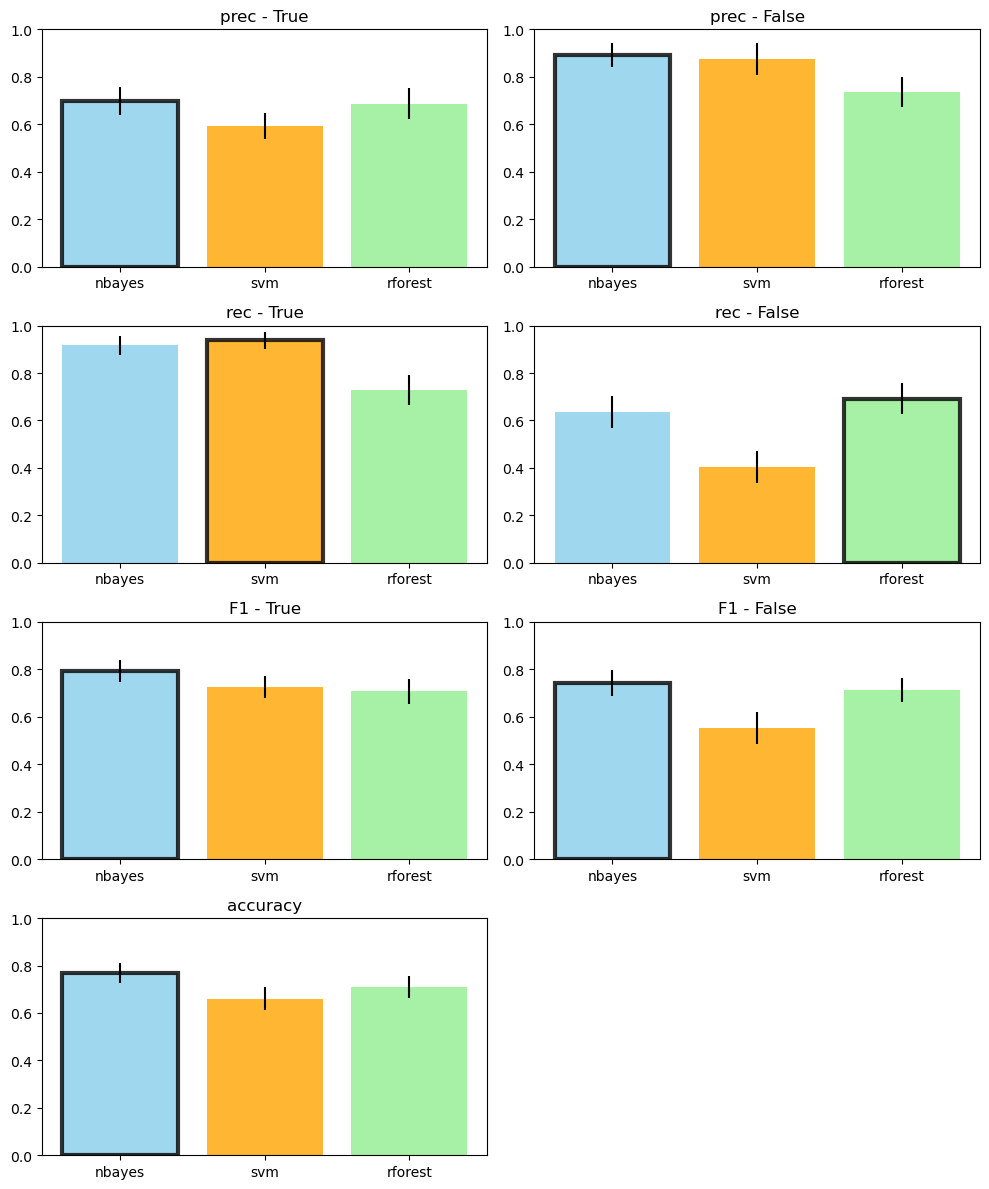

In [24]:
# create relevant variables
colors = ["skyblue", "orange", "lightgreen"]
metrics = list(eval_sl.keys())
metrics.remove("acc") # remove accuracy because of its different structure, will be done manually later
labels = list(eval_sl[metrics[0]].keys())

# create subplots
fig, axs = plt.subplots(len(metrics) + 1, len(labels), figsize=(10, 12)) # 1 row per metric (the +1 is for accuracy), one col per label
fig.delaxes(axs[-1, -1])

index = np.arange(len(eval_sl[metrics[0]][labels[0]])) # custom index is needed to allow for evaluations of twitter and youtube in 1 plot

# visualize label-specific metrics
for i, metric in enumerate(metrics):
    for j, label in enumerate(labels):
        classifiers = eval_sl[metric][label]

        classifiers_names = list(classifiers.keys())
        classifiers_values = [classifier_dict["estimate"] for classifier_dict in classifiers.values()]
        classifiers_ses = [classifier_dict["se"] for classifier_dict in classifiers.values()]

        ax = axs[i, j]
        bars = ax.bar(index, classifiers_values, yerr = classifiers_ses, color = colors, alpha = 0.8)
        
        ax.set_title(f"{metric} - {label}")
        ax.set_xticks(index)
        ax.set_xticklabels(classifiers_names)
        ax.set_ylim(0, 1)
        
        # Highlight the highest value
        max_value = max(classifiers_values)
        max_index = classifiers_values.index(max_value)
        bars[max_index].set_edgecolor("black")
        bars[max_index].set_linewidth(3)

# visualize accuracy
ax = axs[i + 1, 0]
acc_values = [acc_dict["estimate"] for acc_dict in eval_sl["acc"].values()]
acc_ses = [acc_dict["se"] for acc_dict in eval_sl["acc"].values()]
bars_acc = ax.bar(index, acc_values, yerr = acc_ses, color = colors, alpha = 0.8)
ax.set_title("accuracy")
ax.set_xticks(index)
ax.set_xticklabels(classifiers_names)
ax.set_ylim(0, 1)

# mark highest accuracy
max_index_acc = acc_values.index(max(acc_values))
bars_acc[max_index_acc].set_edgecolor("black")
bars_acc[max_index_acc].set_linewidth(3)

plt.tight_layout()
plt.show()

In [25]:
# print accuracies
{classifier : value["estimate"] for classifier, value in eval_sl["acc"].items()}

{'nbayes': 0.77, 'svm': 0.66, 'rforest': 0.71}

Based on these results, I will proceed with the naive bayes classifier, as it provides the highest accuracy as well as the highest F1-scores in the sample. However, based on the uncertainty estimates plotted above, it is important to highlight that this performance might be due to the sample, with especially the random forest algorithm often performing similarly.

In [26]:
# cut down the bag of words for the overall dataset so it only includes the words the naive bayes algorithm was trained with.

video_bow = video_bow[train_x.columns]

In [27]:
# add conspirative label based on naive bayes to dataframe

video_df["conspirative_auto"] = nbayes.predict(video_bow).astype(bool)

video_df.head(3)

,phase,week_start,title,description,views,clean,likes,comments,conspirative_auto,conspirative_manual
video_id,,,,,,,,,,
Gg38BtcNioY,0,2022-03-20,The Office of Community Development! 15-Minute...,🛣️Watch the next episode: https://youtu.be/Vd2...,991,office community development 15 minute city 10...,100.0,64,False,<NA>
Ne6nrlB_3os,0,2022-03-20,URBTalk: 20 Minute Neighbourhood,URBTalk presentation on the 20 minute neighbou...,166,urbtalk 20 minute neighbourhood urbtalk presen...,1.0,0,False,<NA>
2mezuB5BwnA,0,2022-03-20,Expo 2020 Dubai Will Reopen As A 15-Minute Cit...,.,114,expo 2020 dubai reopen 15 minute city 10 pavil...,0.0,0,True,<NA>


In [28]:
write_video_df(video_df)

# 6. Use the emotion classification model LEIA to obtain the sentiments expressed in the comments.

## 6.1 create comment df

In [29]:
# (re-)load video json

video_json = read_video_json()

In [30]:
def init_comment_df(video_json : list) -> pd.DataFrame:
    """Creates an initial video dataframe from video_json. 

    Args:
        video_json (list): Obtained in data_collection

    Returns:
        pd.DataFrame: dataframe containing 1 row per comment, columns include video phase, week of upload, video id, comment id, comment text and empty field for comment sentiment
    """
    
    results = []
    
    for video in video_json:
        try:
            for comment_id, comment_text in video["comments"].items():
                comment_row = {"phase" : video["phase"],
                            "week_start" : video["week_start"],
                            "video_id" : video["video_id"], 
                            "comment_id" : comment_id, 
                            "text" : comment_text}
                results.append(comment_row)
        except Exception as e:
            print(video) 
    return pd.DataFrame(results)

In [32]:
confirm_execution("Do you want to reset the comments df? All automatic labels will be lost.")

comment_df = init_comment_df(video_json)

write_comment_df(comment_df)